### Домашняя работа №6 ###

Попробуйте обучить нейронную сеть U-Net на любом другом датасете.

Буду использовать *Cityscapes*

Опишите результата. Что помогло повысить точность?

*Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview4.

*Сделайте свою реализацию U-Net на TensorFlow

Датасет: https://www.kaggle.com/dansbecker/cityscapes-image-pairs

In [1]:
import numpy as np
from pathlib import Path
from keras.preprocessing import image

In [2]:
# Загружаем изображения
path_train = './cityscapes_data/train/'
path_validation = './cityscapes_data/val/'

#path_img = './data/images'
#path_mask = './data/masks'

#data_image_paths = list(Path(path_img).iterdir())
#mask_image_paths = list(Path(path_mask).iterdir())
train_images_paths = list(Path(path_train).iterdir())
validation_images_paths = list(Path(path_validation).iterdir())

In [3]:
single_image = image.load_img(train_images_paths[0])
image_size = (int(single_image.size[0]/2), single_image.size[1])
image_size

(256, 256)

In [4]:
def load_images_with_masks(paths):
    images = []
    masks = []

    for path in train_images_paths:
        temp_img = image.load_img(path) 
        img = temp_img.crop((0, 0, image_size[0], image_size[1])) 
        mask = temp_img.crop((image_size[0], 0, image_size[0] * 2, image_size[1]))
        images.append(img)
        masks.append(mask)

    return images, masks

def load_images(paths):
    images = []
    for path in paths:
        img = image.load_img(path)
        images.append(img)
    
    return images
        #data_img = image.load_img(path) 
        #mask_img = image.load_img(path)

images, masks = load_images_with_masks(train_images_paths)
#images = load_images(data_image_paths)

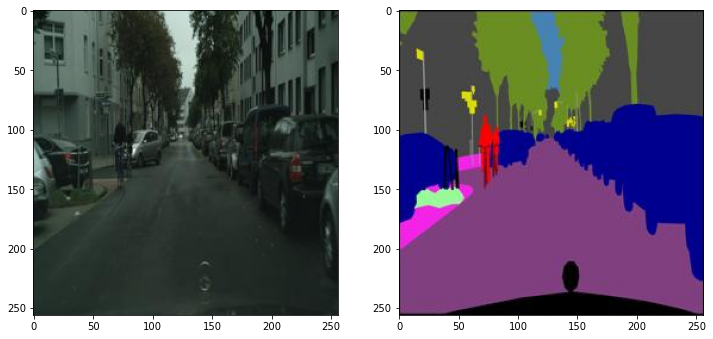

In [5]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(images[10].convert('RGBA'))
ax[1].imshow(masks[10].convert('RGBA'))

In [6]:
def extract_classes_from_masks(masks, gradations_number=3):
    classes = set()
    max_color_value = 255
    color_group_divider = int(max_color_value / gradations_number) 

    for mask in masks:
        for pixel in masks[0].convert('RGBA').getdata():
            r = int(pixel[0] / color_group_divider) * color_group_divider
            g = int(pixel[1] / color_group_divider) * color_group_divider
            b = int(pixel[2] / color_group_divider) * color_group_divider
            classes.add((r, g, b,))

    return [[item[0], item[1], item[2]] for item in list(classes)]


In [7]:
#RGB
classes = extract_classes_from_masks(masks, 3)

In [8]:
def get_X_from_images(images):
    X = []

    for img in images:
        x = image.img_to_array(img)
        X.append(x)

    X = np.array(X)

    return X

In [9]:
X = get_X_from_images(images)

In [10]:
X

array([[[[180., 207., 202.],
         [177., 204., 199.],
         [124., 151., 146.],
         ...,
         [ 27.,  43.,  33.],
         [ 34.,  52.,  40.],
         [ 24.,  42.,  30.]],

        [[179., 206., 201.],
         [177., 204., 199.],
         [124., 151., 146.],
         ...,
         [ 54.,  70.,  60.],
         [ 26.,  44.,  32.],
         [ 46.,  64.,  52.]],

        [[176., 205., 201.],
         [175., 204., 200.],
         [123., 152., 148.],
         ...,
         [ 33.,  49.,  39.],
         [ 20.,  38.,  26.],
         [ 38.,  56.,  44.]],

        ...,

        [[ 84., 103.,  84.],
         [ 84., 103.,  84.],
         [ 84., 103.,  84.],
         ...,
         [ 55.,  71.,  61.],
         [ 55.,  71.,  61.],
         [ 55.,  71.,  61.]],

        [[ 82., 101.,  82.],
         [ 83., 102.,  83.],
         [ 83., 102.,  83.],
         ...,
         [ 55.,  71.,  61.],
         [ 55.,  71.,  61.],
         [ 55.,  71.,  61.]],

        [[ 81., 100.,  81.],
       

In [11]:
def Color2index(y, classes):
    y_ind = np.zeros((y.shape[0], y.shape[1]))
    y_cat = np.zeros((y.shape[0], y.shape[1], len(classes)))
    i = 1
    for color in classes:
        ind_i = np.where(
            (y[..., 0] >= color[0]) & (y[..., 0] <= color[0] + 85) 
            & (y[..., 1] >= color[1]) & (y[..., 1] <= color[1] + 85)
            & (y[..., 2] >= color[2]) & (y[..., 2] <= color[2] + 85)
        )
        y_ind[ind_i[0], ind_i[1]] = i
        y_cat[ind_i[0], ind_i[1], i-1] = 1 
        i += 1
    
    return y_cat, y_ind

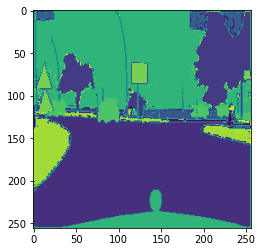

In [12]:
from keras.preprocessing import image
cat_yi, ind_yi = Color2index(image.img_to_array(masks[0]), classes)

plt.imshow(ind_yi)
plt.show()  

In [13]:
ind_yi

array([[20., 20., 20., ..., 20., 20., 20.],
       [20.,  4., 15., ..., 29., 29., 20.],
       [20., 15., 21., ...,  6.,  6., 20.],
       ...,
       [20.,  5.,  5., ...,  5.,  5., 20.],
       [20., 20., 20., ..., 20., 20., 20.],
       [20., 20., 20., ..., 20., 20., 20.]])

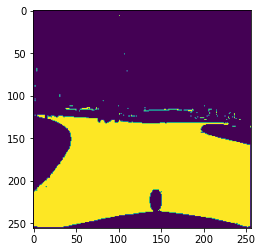

In [14]:
plt.imshow(cat_yi[..., 4])
plt.show()

In [15]:
cat_yi.shape

(256, 256, 30)

In [16]:
def get_target_from_masks(masks):
  y = []

  for mask in masks[0:500]:
    y_cat, y_in = Color2index(image.img_to_array(mask), classes)
    y.append(y_cat)

  y = np.array(y)

  return y

In [17]:
y = get_target_from_masks(masks)

In [18]:
classes

[[85, 0, 0],
 [170, 170, 170],
 [170, 0, 85],
 [0, 85, 85],
 [85, 0, 85],
 [85, 85, 0],
 [170, 85, 0],
 [85, 0, 170],
 [170, 0, 170],
 [0, 85, 170],
 [85, 255, 85],
 [170, 255, 85],
 [255, 0, 170],
 [170, 85, 85],
 [85, 85, 85],
 [170, 255, 170],
 [85, 255, 170],
 [255, 0, 255],
 [170, 85, 170],
 [0, 0, 0],
 [85, 85, 170],
 [0, 0, 85],
 [85, 170, 0],
 [170, 170, 0],
 [0, 0, 170],
 [85, 170, 85],
 [170, 170, 85],
 [170, 0, 0],
 [0, 85, 0],
 [85, 170, 170]]

In [19]:
y.shape

(500, 256, 256, 30)

In [20]:
y[0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

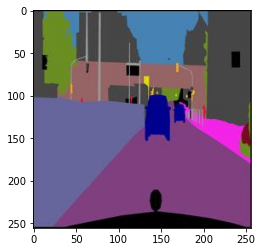

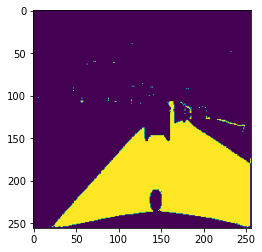

In [21]:
n = 4
plt.imshow(masks[n].convert('RGBA'))
plt.show()
img = y[n][..., 4]

plt.imshow(img)
plt.show()

In [22]:
N = 300
y_train = y[:N, ...]
X_train = X[:N, ...]

y_test = y[N:, ...]
X_test = X[N:, ...]

In [23]:
y_test.shape

(200, 256, 256, 30)

In [24]:
print(X_train.shape)
print(y_train.shape)

(300, 256, 256, 3)
(300, 256, 256, 30)


In [32]:
from keras.models import Model
from keras.layers import (Activation, Input, MaxPooling2D, BatchNormalization, Conv2D, Conv2DTranspose, concatenate)
from tensorflow.keras.utils import plot_model

def Unet(num_classes=30, input_shape=(256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)


    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)


    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)


    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)

    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

 
    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    return model

In [33]:
import keras.backend as K

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred)) / (K.sum(y_true) + K.sum(y_pred))

In [34]:
import keras
from IPython.display import clear_output


def show_predictions(model):
    pred_mask = model.predict(sample_image[None])[..., 0]
    print(pred_mask.shape)

    fig, ax = plt.subplots(1, 3, figsize=(15, 8))

    ax[0].imshow(sample_image / 255.0)
    ax[1].imshow(sample_mask[..., 0])
    ax[2].imshow(np.squeeze(pred_mask, axis=0))
    plt.show()


class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, patience=1):
        super().__init__()
        self.patience = patience
    
    def on_train_begin(self, logs=None):
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        self.wait += 1
        if self.wait >= self.patience:
            clear_output(wait=True)
            show_predictions(self.model)
            print(f'\nSample Prediction after epoch {epoch+1}')
            self.wait = 0

In [35]:
import tensorflow
from tensorflow.keras.optimizers import Adam

model = Unet()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[dice_coef])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

In [36]:
X_train[0], y_train[0]

(array([[[180., 207., 202.],
         [177., 204., 199.],
         [124., 151., 146.],
         ...,
         [ 27.,  43.,  33.],
         [ 34.,  52.,  40.],
         [ 24.,  42.,  30.]],
 
        [[179., 206., 201.],
         [177., 204., 199.],
         [124., 151., 146.],
         ...,
         [ 54.,  70.,  60.],
         [ 26.,  44.,  32.],
         [ 46.,  64.,  52.]],
 
        [[176., 205., 201.],
         [175., 204., 200.],
         [123., 152., 148.],
         ...,
         [ 33.,  49.,  39.],
         [ 20.,  38.,  26.],
         [ 38.,  56.,  44.]],
 
        ...,
 
        [[ 84., 103.,  84.],
         [ 84., 103.,  84.],
         [ 84., 103.,  84.],
         ...,
         [ 55.,  71.,  61.],
         [ 55.,  71.,  61.],
         [ 55.,  71.,  61.]],
 
        [[ 82., 101.,  82.],
         [ 83., 102.,  83.],
         [ 83., 102.,  83.],
         ...,
         [ 55.,  71.,  61.],
         [ 55.,  71.,  61.],
         [ 55.,  71.,  61.]],
 
        [[ 81., 100.,  81.],
 

In [37]:
print(X_test.shape)
print(y_test.shape)

(2675, 256, 256, 3)
(200, 256, 256, 30)


In [38]:
fit_limit = {
    'train': 400,
    'test': 100
}
history = model.fit(
    X_train[0:fit_limit['train']], 
    y_train[0:fit_limit['train']],
    epochs=3,
    batch_size=1,
    validation_data=(X_test[0:fit_limit['test']], y_test[0:fit_limit['test']]),
    callbacks=[DisplayCallback(patience=5)]
)

Epoch 1/3
300/300 [==============================] - 868s 3s/step - loss: 1.2345 - dice_coef: 0.4991 - val_loss: 2.7095 - val_dice_coef: 0.3846
Epoch 2/3
300/300 [==============================] - 852s 3s/step - loss: 1.0505 - dice_coef: 0.5594 - val_loss: 1.3607 - val_dice_coef: 0.5216
Epoch 3/3
300/300 [==============================] - 857s 3s/step - loss: 0.9993 - dice_coef: 0.5793 - val_loss: 1.1454 - val_dice_coef: 0.5850


In [42]:
MODEL_WEIGHTS_PATH = 'model_weights.h5'
MODEL_PATH = 'model_save'

In [40]:
model.save_weights(MODEL_WEIGHTS_PATH)

In [43]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: model_save\assets


In [44]:
model.load_weights(MODEL_WEIGHTS_PATH)

In [45]:
val_images, val_masks = load_images_with_masks(validation_images_paths)

In [46]:
X_val = get_X_from_images(val_images)

In [47]:
y_val = get_target_from_masks(val_masks)

In [ ]:
pred = model.predict(X_val[0:50])
print(pred.shape)

In [ ]:
n = 11
class_ = 4
plt.imshow(val_images[n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(val_masks[n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()

img = y_val[n][..., class_]
plt.imshow(img)
plt.title('целевая разметка класс: ' + str(class_))
plt.show()
img = pred[n - 1][..., class_]
plt.imshow(img)
plt.title('предиктивная разметка класс: ' + str(class_))
plt.show()

Удалось обучить нейронную сеть различать размеченные классы на фотографиях.

На последнем изображении продемонстрировано определение класса дороги. 

Обучение требовало значительных системных ресурсов. В частности столкнулся с нехваткой оперативной памяти.

Как вариант для решения проблемы можно использовать предобученные сети (VGG16) или дообучить имеющуюся модель.